based on https://github.com/uygarkurt/DDPM-Image-Generation/blob/main/DDPM_Image_Generartion.ipynb

In [1]:
from IPython.display import display, Markdown, HTML, clear_output

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim import SGD
from torch.utils.data import DataLoader, TensorDataset

from torchvision import transforms
from torchvision.models import inception_v3
from torchvision.transforms import ToTensor, Resize, Normalize, Compose


from diffusers import UNet2DModel, DDPMScheduler, DDPMPipeline
from diffusers.optimization import get_cosine_schedule_with_warmup

from datasets import load_dataset

from accelerate import Accelerator

from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import random
import timeit
import json

import os
import time

import numpy as np
from scipy.linalg import sqrtm


# ignore UserWarning
import warnings
warnings.filterwarnings("ignore")

In [3]:
RANDOM_SEED = 42
IMG_SIZE = 128
DATASET_PERCENTAGE = 0.001
BATCH_SIZE = 8
LEARNING_RATE = 1e-4
NUM_EPOCHS = 5
NUM_GENERATE_IMAGES = 9
NUM_TIMESTEPS = 500
MIXED_PRECISION = "fp16"
GRADIENT_ACCUMULATION_STEPS = 1

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
# torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
local_dataset_path = f"data/square{IMG_SIZE}_random{str(DATASET_PERCENTAGE)}/"
dataset = load_dataset("imagefolder", data_dir=local_dataset_path)
dataset = dataset["train"]
clear_output()

In [5]:
preprocess = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

In [6]:
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}


dataset.set_transform(transform)

In [7]:
train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


In [8]:
# model_small = UNet2DModel(
#     sample_size=IMG_SIZE,
#     in_channels=3,
#     out_channels=3,
#     layers_per_block=1,
#     block_out_channels=(64, 64, 128, 128, 256),
#     down_block_types=(
#         "DownBlock2D",
#         "DownBlock2D",
#         "DownBlock2D",
#         "DownBlock2D",
#         "AttnDownBlock2D",
#     ),
#     up_block_types=(
#         "AttnUpBlock2D",
#         "UpBlock2D",
#         "UpBlock2D",
#         "UpBlock2D",
#         "UpBlock2D",
#     ),
# )
# model_small = model_small.to(device)

model_mid = UNet2DModel(
    sample_size=IMG_SIZE,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(128, 128, 256, 256, 512, 512),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)
model_mid = model_mid.to(device)


# model_big = UNet2DModel(
#     sample_size=IMG_SIZE,
#     in_channels=3,
#     out_channels=3,
#     layers_per_block=3,
#     block_out_channels=(128, 256, 256, 512, 512, 768),
#     down_block_types=(
#         "DownBlock2D",
#         "DownBlock2D",
#         "DownBlock2D",
#         "DownBlock2D",
#         "AttnDownBlock2D",
#         "DownBlock2D",
#     ),
#     up_block_types=(
#         "UpBlock2D",
#         "UpBlock2D",
#         "UpBlock2D",
#         "UpBlock2D",
#         "AttnUpBlock2D",
#         "UpBlock2D",
#     ),
# )

In [9]:
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2):
    """Calculate the Fréchet Distance between two multivariate Gaussians."""
    covmean, _ = sqrtm(sigma1 @ sigma2, disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    diff = mu1 - mu2
    return diff @ diff + np.trace(sigma1 + sigma2 - 2 * covmean)


def get_activations(model, dataloader, device, key):
    """Get activations of the dataset images using the InceptionV3 model."""
    model.eval()
    activations = []

    for batch in tqdm(dataloader, desc="Calculating activations", leave=False):
        images = batch[key].to(device)
        with torch.no_grad():
            preds = model(images)
        activations.append(preds.cpu().numpy())

    activations = np.concatenate(activations, axis=0)
    return activations


def calculate_statistics(activations):
    """Calculate mean and covariance matrix of activations."""
    mu = np.mean(activations, axis=0)
    sigma = np.cov(activations, rowvar=False)
    return mu, sigma


def sample_image_generation(
    model,
    noise_scheduler,
    num_generate_images,
    random_seed,
    num_timesteps,
    device,
    accelerator,
):
    # Unwrap the model and inspect its attributes
    unwrapped_model = accelerator.unwrap_model(model)
    # print("Unwrapped Model:", unwrapped_model)
    # print("Model Config:", getattr(unwrapped_model, 'config', 'No config attribute'))

    # Create the pipeline and inspect its attributes
    pipeline = DDPMPipeline(
        unet=unwrapped_model, 
        scheduler=noise_scheduler
    )
    # print("Pipeline UNet Config:", getattr(pipeline.unet, 'config', 'No config attribute'))

    # Generate images
    images = pipeline(
        batch_size=num_generate_images,
        generator=torch.manual_seed(random_seed),
        num_inference_steps=num_timesteps,
    ).images

    

 
    

    # Transform images to tensor and normalize
    transform = preprocess

    transformed_images = torch.stack([transform(image) for image in images]).to(device)
    return transformed_images


def calculate_fid(
    model,
    dataloader_real,
    num_generated_images,
    noise_scheduler,
    random_seed,
    num_timesteps,
    device,
    accelerator,
):
    """Calculate FID score for real and generated images."""
    # Load InceptionV3 model
    inception = inception_v3(pretrained=True, transform_input=False)
    inception.fc = nn.Identity()  # Remove the last fully connected layer
    inception.to(device)

    # Get activations for real images
    real_activations = get_activations(inception, dataloader_real, device, key=0)

    # Generate images and get activations for generated images
    generated_images = []
    for _ in range(0, num_generated_images, 32):
        generated_images.append(
            sample_image_generation(
                model,
                noise_scheduler,
                32,
                random_seed,
                num_timesteps,
                device,
                accelerator,
            )
        )
    generated_images_ = torch.cat(generated_images, dim=0)
    
    generated_dataset = TensorDataset(generated_images)
    generated_dataloader = DataLoader(generated_dataset, batch_size=32, shuffle=False)
    generated_activations = get_activations(
        inception, generated_dataloader, device, key=0
    )

    # Calculate statistics
    mu_real, sigma_real = calculate_statistics(real_activations)
    mu_generated, sigma_generated = calculate_statistics(generated_activations)

    # Calculate FID
    fid_score = calculate_frechet_distance(
        mu_real, sigma_real, mu_generated, sigma_generated
    )
    return fid_score


transform = preprocess

In [10]:
from copy import deepcopy
if os.path.exists(f"models/ddpm/hypers/{DATASET_PERCENTAGE}/2024-06-09_18-20-09-mid-Adam-0.0001-0-0.1-128/model.pth"):
    print("Model exists. Skipping training.")
    model_mid = model_mid.load_state_dict(torch.load(f"models/ddpm/hypers/{DATASET_PERCENTAGE}/2024-06-09_18-20-09-mid-Adam-0.0001-0-0.1-128/model.pth"))
    noise_scheduler = torch.load(f"models/ddpm/hypers/{DATASET_PERCENTAGE}/2024-06-09_18-20-09-mid-Adam-0.0001-0-0.1-128/noise_scheduler.pth")
    accelerator = Accelerator(
        mixed_precision=MIXED_PRECISION,
        gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    )
    
else:
    for unet_size in ([
        # "small", 
        "mid", 
        # "big"
        ]):
        for learning_rate in [
            # LEARNING_RATE / 10, 
            LEARNING_RATE, 
            # LEARNING_RATE * 10
            ]:
            for optimizer_type in [
                "Adam", 
                # "SGD"
                ]:
                for n_seeds in range(1):
                    loss_is_nan = False

                    # model = deepcopy(model_small) if unet_size == "small" else deepcopy(model_mid) if unet_size == "mid" else deepcopy(model_big) 
                    model = deepcopy(model_mid) 

                    
                    print(f"UNET Size: {unet_size}, Learning Rate: {learning_rate}, Optimizer: {optimizer_type}")


                    if optimizer_type == "Adam":
                        optimizer = AdamW(model.parameters(), lr=learning_rate)
                    elif optimizer_type == "SGD":
                        optimizer = SGD(model.parameters(), lr=learning_rate)

                    training_loss = []
                    # frechet_inception_distance = []
                    # frechet_inception_distance_epochs = []

                    lr_scheduler = get_cosine_schedule_with_warmup(
                        optimizer=optimizer,
                        num_warmup_steps=500,
                        num_training_steps=len(train_dataloader) * NUM_EPOCHS,
                    )
                    
                    noise_scheduler = DDPMScheduler(num_train_timesteps=NUM_TIMESTEPS)

                    accelerator = Accelerator(
                        mixed_precision=MIXED_PRECISION,
                        gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
                    )

                    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
                        model, optimizer, train_dataloader, lr_scheduler
                    )

                    start = timeit.default_timer()

                    for epoch in tqdm(range(NUM_EPOCHS), position=0, leave=True, desc="EPOCHS"):

                        def seed_worker(worker_id):
                            worker_seed = torch.initial_seed() % 2**32
                            np.random.seed(worker_seed)
                            random.seed(worker_seed)

                        g = torch.Generator()
                        g.manual_seed(n_seeds)

                        train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, worker_init_fn=seed_worker, generator=g)


                        model.train()

                        train_running_loss = 0

                        for idx, batch in enumerate(
                            tqdm(train_dataloader, position=0, desc="BATCHES", leave=False)
                        ):

                            clean_images = batch["images"].to(device)

                            noise = torch.randn(clean_images.shape).to(device)

                            last_batch_size = len(clean_images)

                            timesteps = torch.randint(
                                0,
                                noise_scheduler.config.num_train_timesteps,
                                (last_batch_size,),
                            ).to(device)

                            noisy_images = noise_scheduler.add_noise(
                                clean_images, noise, timesteps
                            )

                            with accelerator.accumulate(model):

                                noise_pred = model(noisy_images, timesteps, return_dict=False)[
                                    0
                                ]
                                loss = F.mse_loss(noise_pred, noise)
                                accelerator.backward(loss)

                                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                                optimizer.step()
                                lr_scheduler.step()
                                optimizer.zero_grad()

                            train_running_loss += loss.item()
                        train_loss = train_running_loss / (idx + 1)


                    
                        

                        training_loss.append(train_loss)
                    

                        train_learning_rate = lr_scheduler.get_last_lr()[0]

                        print("-" * 30)

                        print(f"Train Loss EPOCH: {epoch+1}: {train_loss:.4f}")

                        print(f"Train Learning Rate EPOCH: {epoch+1}: {train_learning_rate}")


                        print("-" * 30)

                        # if train_loss is not a number, break
                        if train_loss != train_loss:
                            print("Loss is NaN. Exiting training.")
                            loss_is_nan = True
                            break

                    stop = timeit.default_timer()

                    print(f"Training Time: {stop-start:.2f}s")

                    # save model with date and time in a folder
                    if learning_rate == 1e-5:
                        learning_rate_str = "0.00001"
                    else:
                        learning_rate_str = str(learning_rate)
                    os.makedirs("models", exist_ok=True)
                    time_ = time.strftime("%Y-%m-%d_%H-%M-%S")
                    model_path = f"models/ddpm/hypers/{DATASET_PERCENTAGE}/{time_}-{unet_size}-{optimizer_type}-{learning_rate_str}-{n_seeds}-{DATASET_PERCENTAGE}-{IMG_SIZE}"
                    os.makedirs(model_path, exist_ok=True)
                    
                    

                    torch.save(model.state_dict(), f"{model_path}/model.pth")
                    torch.save(optimizer.state_dict(), f"{model_path}/optimizer.pth")
                    torch.save(lr_scheduler.state_dict(), f"{model_path}/lr_scheduler.pth")
                    torch.save(noise_scheduler, f"{model_path}/noise_scheduler.pth")

                    metadata = {
                        "IMG_SIZE": IMG_SIZE,
                        "BATCH_SIZE": BATCH_SIZE,
                        "LEARNING_RATE": learning_rate,
                        "NUM_EPOCHS": NUM_EPOCHS,
                        "NUM_GENERATE_IMAGES": NUM_GENERATE_IMAGES,
                        "NUM_TIMESTEPS": NUM_TIMESTEPS,
                        "MIXED_PRECISION": MIXED_PRECISION,
                        "GRADIENT_ACCUMULATION_STEPS": GRADIENT_ACCUMULATION_STEPS,
                        "losses": training_loss,
                        # "fid_scores": frechet_inception_distance,
                        # "fid_scores_epochs": frechet_inception_distance_epochs,
                        "dataset": f"square{IMG_SIZE}_random{str(DATASET_PERCENTAGE)}",
                        "UNET_size": unet_size,
                        "optimizer": optimizer_type,
                        'seed': n_seeds,
                        'exited_loss_na': loss_is_nan,
                        'execution_time': stop-start,


                    }

                    with open(f"{model_path}/metadata.json", "w") as f:
                        json.dump(metadata, f)

                    clear_output()

                
            

In [11]:
images = sample_image_generation(
    model_mid,
    noise_scheduler,
    num_generate_images=9,
    random_seed=42,
    num_timesteps=NUM_TIMESTEPS,
    device=device,
    accelerator=accelerator,
)

  0%|          | 0/500 [00:00<?, ?it/s]

In [12]:
# process images
images = images.cpu().numpy()
images = (images + 1) / 2

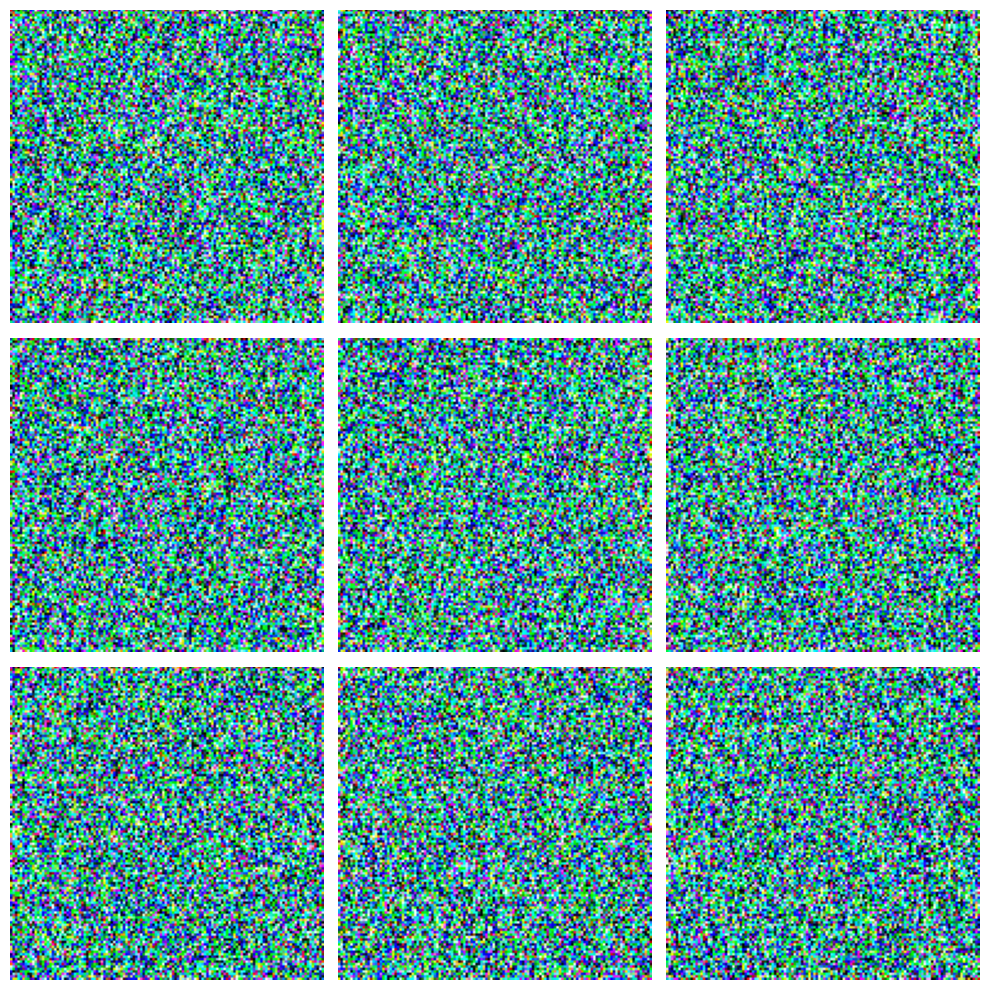

In [13]:
# plot images
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.imshow(images[i].transpose(1, 2, 0))
    ax.axis("off")
plt.tight_layout()

In [14]:
NUM_GENERATE_IMAGES = 100

# random 1000 indices 
random_indices = np.random.choice(len(dataset), NUM_GENERATE_IMAGES, replace=False)

images = dataset[random_indices]['images']
dataset_1000_images = TensorDataset(
    torch.stack([image for image in images])
)
dataloader_1000_images = DataLoader(dataset_1000_images, batch_size=32, shuffle=False)


In [15]:
fid = calculate_fid(
    model,
    dataloader_1000_images,
    num_generated_images=NUM_GENERATE_IMAGES,
    noise_scheduler=noise_scheduler,
    random_seed=42,
    num_timesteps=NUM_TIMESTEPS,
    device=device,
    accelerator=accelerator,
)

Calculating activations:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

AttributeError: 'list' object has no attribute 'size'

In [ ]:
for value in dataloader_1000_images:
    print(len(value[0]))
    break

32
